In [2]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 모델 로드
model = BertForSequenceClassification.from_pretrained('./saved_model')
tokenizer = BertTokenizer.from_pretrained('./saved_model')

# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# 데이터셋 정의
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        label = self.labels[idx]
        
        # 1~5 label을 True, 0 label을 False로 변환
        if label in [1, 2, 3, 4, 5]:
            label = 1
        else:
            label = 0
        
        return {
            'input_ids': inputs['input_ids'].flatten().to(device),
            'attention_mask': inputs['attention_mask'].flatten().to(device),
            'labels': torch.tensor(label, dtype=torch.long).to(device)
        }
    

# 데이터 로드
df = pd.read_csv('data/moralTest.csv')

# 데이터를 1000개로 제한
X_train, X_test, y_train, y_test = train_test_split(df['text'].sample(1000), df['types'].sample(1000), test_size=0.2, random_state=42)

train_dataset = HateSpeechDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = HateSpeechDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# 평가
model.eval()
predictions, true_labels = [], []
num = 0
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    batch_predictions = torch.argmax(logits, dim=1).tolist()
    batch_true_labels = batch['labels'].tolist()
    
    for i, (text, pred, true_label) in enumerate(zip(X_test, batch_predictions, batch_true_labels)):
        if pred == true_label:
            num += 1
        print(f"Text: {text}")
        print(f"Predicted Label: {pred}")
        print(f"True Label: {true_label}")
        print()

accuracy = num / len(X_test)
print(f"Accuracy: {accuracy:.2f}")


Text: 음식에 양배추 좀 그만 처넣어라
Predicted Label: 0
True Label: 0

Text: 예쁘면 세상 살기 편하더라
Predicted Label: 1
True Label: 0

Text: 뒷광고하는 유튜버들 아직도 활동해?
Predicted Label: 1
True Label: 1

Text: ㄱㄴㄲ; 나중엔 강남 오피녀들도 #@#라고 하겠노
Predicted Label: 0
True Label: 1

Text: 쉴드를 칠 걸 처라
Predicted Label: 1
True Label: 0

Text: 나 나이를 먹을수록 점점 추위를 많이타는 것 같애
Predicted Label: 1
True Label: 1

Text: 그 색희 이제 사회에서도 매장이네
Predicted Label: 0
True Label: 1

Text: 쟤네는 저런 쓰레기 낳아놔서 어떡하냐 ㅋㅋㅋ 불쌍
Predicted Label: 0
True Label: 1

Text: 미쳤다 댓글들 센스 찢었다 진심 ㅋㅋㅋ
Predicted Label: 1
True Label: 1

Text: 부모 얼굴도 모르는 애들이 뭔 힘아리가 있겠냐 ㅋㅋ 고아원에서 주는 밥이나 꾸역꾸역 먹는 애들
Predicted Label: 0
True Label: 0

Text: 진짜 알아서 분리수거함으로 들어가주네요.
Predicted Label: 1
True Label: 0

Text: 쟤 지금 옥수수만 몇개째야?
Predicted Label: 1
True Label: 1

Text: 쟤 분명 나가서 너 예민하다고 욕했을 듯
Predicted Label: 0
True Label: 1

Text: 의료시설도 조선시대라 알아서 저승길 건너서 염라대왕 앞에 직배송될테니까
Predicted Label: 0
True Label: 1

Text: 그래도 계속 벌레인 것보단 나비로 변하는 게 낫지.
Predicted Label: 0
True Label: 1

Text: 니처럼 열심히 해봐야 의미 없다
Pre

Text: 요즘 다들 공무원 공무원 하는데 난 공무원 체질은 아니야
Predicted Label: 1
True Label: 0

Text: 한번쯤은 괜찮겠지 하고 타는 순간 바다로 떨어져서 갈가리 상어 밥 되는 거지
Predicted Label: 1
True Label: 5

Text: 너나 처먹지 마라.
Predicted Label: 4
True Label: 4

Text: 연예인들은 그걸 감수하고 해야 하는 거야. 하다 못해 입은 속옷도 보여줘야지.
Predicted Label: 0
True Label: 0

Text: 와 ㄹㅇ상남자네 ㅋㅋㅋ 빠꾸없이 말하네
Predicted Label: 0
True Label: 0

Text: 선동하는 꼬라지 하고는
Predicted Label: 4
True Label: 0

Text: 너도 정상은 아니구나?
Predicted Label: 0
True Label: 0

Text: 인성 교육도 못 받은 너보단 공부라도 한 내가 낫다
Predicted Label: 5
True Label: 4

Text: 돈자랑은 더럽게 많이 해 하여튼
Predicted Label: 0
True Label: 0

Text: 그러게나말이다 뭐가 문제인거지
Predicted Label: 0
True Label: 0

Text: 아우 침대 밑에 이 먼지들 봐
Predicted Label: 5
True Label: 5

Text: 근데 쌍수만 한 게 아닌 것 같아
Predicted Label: 0
True Label: 3

Text: 진심 아저씨 문열고 밀어버리고 싶었음
Predicted Label: 0
True Label: 0

Text: 그냥 친구야, 오해하지 마. 나 못 믿어?
Predicted Label: 5
True Label: 1

Text: 한남들 단체로 거기에 필러나 맞아라
Predicted Label: 0
True Label: 0

Text: 그래? 그럼 너가 치킨 사. 내가 특별히 다리랑 날개 다 먹어줄게
Predicted Labe

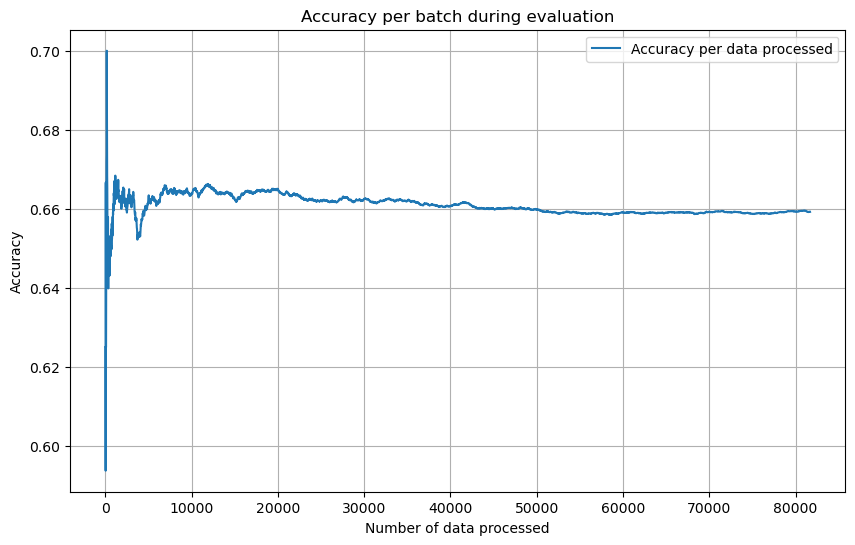

In [3]:
# moral 평가

import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

# 모델 로드
model = BertForSequenceClassification.from_pretrained('./saved_model')
tokenizer = BertTokenizer.from_pretrained('./saved_model')

# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# 데이터셋 정의
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        label = self.labels[idx]
        return {
            'input_ids': inputs['input_ids'].flatten().to(device),
            'attention_mask': inputs['attention_mask'].flatten().to(device),
            'labels': torch.tensor(label, dtype=torch.long).to(device)
        }
    

# 데이터 로드
df = pd.read_csv('data/moralTest.csv')

X = df['text'].tolist()
y = df['types'].tolist()

test_dataset = HateSpeechDataset(X, y, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# 평가
model.eval()
correct = 0
total = 0
offset = 0  # 추가된 코드: 각 배치의 시작 인덱스를 추적하기 위함
data_processed = []  # 처리된 데이터의 총량을 저장할 리스트
accuracies = []  # 배치별 정확도를 저장할 리스트

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    batch_predictions = torch.argmax(logits, dim=1).tolist()
    batch_true_labels = batch['labels'].tolist()
    
    for i in range(len(batch_predictions)):
        text = X[offset + i]
        pred = batch_predictions[i]
        true_label = batch_true_labels[i]
        print(f"Text: {text}")
        print(f"Predicted Label: {pred}")
        print(f"True Label: {true_label}")
        print()
        if pred == true_label:
            correct += 1
    total += len(batch_predictions)
    offset += len(batch_predictions)  # 각 배치 후 인덱스 업데이트

    # 각 배치 후 정확도 계산하여 리스트에 추가
    batch_accuracy = correct / total
    accuracies.append(batch_accuracy)
    data_processed.append(total)    # 처리된 데이터의 총량을 리스트에 추가

# 최종 정확도
final_accuracy = correct / total
print(f"Final Accuracy: {final_accuracy:.2f}")

# 정확도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(data_processed, accuracies, label='Accuracy per data processed')  # x축을 처리된 데이터의 총량으로 변경
plt.xlabel('Number of data processed')
plt.ylabel('Accuracy')
plt.title('Accuracy per batch during evaluation')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_graph.png')  # 그래프를 파일로 저장
plt.show()


In [ ]:
# moralTF 평가
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

# 모델 로드
model = BertForSequenceClassification.from_pretrained('./saved_model')
tokenizer = BertTokenizer.from_pretrained('./saved_model')

# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# 데이터셋 정의
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        label = self.labels[idx]
        return {
            'input_ids': inputs['input_ids'].flatten().to(device),
            'attention_mask': inputs['attention_mask'].flatten().to(device),
            'labels': torch.tensor(label, dtype=torch.long).to(device)
        }
    

# 데이터 로드
df = pd.read_csv('data/test.csv')

#df = df.sample(n=1000, random_state=42)
X = df['text'].tolist()
y = df['types'].tolist()

test_dataset = HateSpeechDataset(X, y, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# 평가
model.eval()
correct = 0
total = 0
data_processed = []  # 처리된 데이터의 총량을 저장할 리스트
accuracies = []  # 각 스텝에서의 정확도를 저장할 리스트

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    batch_predictions = torch.argmax(logits, dim=1).tolist()
    batch_true_labels = batch['labels'].tolist()
    
    for i in range(len(batch_predictions)):
        text = X[offset + i]
        pred = batch_predictions[i]
        true_label = batch_true_labels[i]
        print(f"Text: {text}")
        print(f"Predicted Label: {pred}")
        print(f"True Label: {true_label}")
        print()
        if pred == true_label:
            correct += 1
    total += len(batch_predictions)
    offset += len(batch_predictions)  # 각 배치 후 인덱스 업데이트
    
    # 각 배치 후 정확도 계산하여 리스트에 추가
    batch_accuracy = correct / total
    accuracies.append(batch_accuracy)
    data_processed.append(total)  # 처리된 데이터의 총량을 리스트에 추가

# 최종 정확도
final_accuracy = correct / total
print(f"Final Accuracy: {final_accuracy:.2f}")

# 정확도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(data_processed, accuracies, label='Accuracy per data processed')  # x축을 처리된 데이터의 총량으로 변경
plt.xlabel('Number of data processed')
plt.ylabel('Accuracy')
plt.title('Accuracy per data processed during evaluation')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_graph.png')  # 그래프를 파일로 저장
plt.show()
